<a href="https://colab.research.google.com/github/olorunfemibabalola/Depression-Tweet-Classifier/blob/main/MLA_UI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PROJECT:** Depression Risk and Intent Classifier for Tweets

**UNIT:** Machine Learning and Applications

**AUTHOR:** Babalola Praise Olorunfemi

**STUDENT ID:** s5819556

LIBRARY SETUP

In [1]:
print("\n🔄 EXECUTING -> Setting up libraries...")
!pip install shap nltk pandas numpy scikit-learn matplotlib seaborn requests beautifulsoup4 imbalanced-learn
print("\n✅ Libraries succesfully installed!!")


🔄 EXECUTING -> Setting up libraries...
✅ Libraries succesfully installed!!


In [2]:
print("\n🔄 EXECUTING -> Importing libraries...")
import pandas as pd
import numpy as np
import re
import nltk
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, recall_score, f1_score, accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler

print("\n\n✅ Libraries imported successfully!")


🔄 EXECUTING -> Importing libraries...
✅ Libraries imported successfully!


In [3]:
# Download necessary NLTK lexicons (Quietly)
nltk.download('vader_lexicon', quiet=True)
nltk.download('stopwords', quiet=True)

True

In [4]:
# Configuration for Reproducibility
RANDOM_STATE = 42
MAX_FEATURES = 1000  # For TF-IDF to keep training fast

**DATA ACQUISITION / SYNTHESIS**

**DATA SYNTHESIS:**
This function generates synthetic data if real data is missing. It's like a backup dataset!
Ensures the pipeline runs immediately without crashing.
    

In [5]:
def generate_synthetic_data(n_samples=3000):

    print("\n⚠️  DATA STATUS: Real CSV not found. Generating SYNTHETIC DATA...")

    data = {'text': [], 'risk_label': [], 'intent': []}

    # Intent: Cry for Help (High Risk)
    helps = [
        "I can't do this anymore, please someone help.", "Planning to end it tonight.",
        "There is no hope left, I want the pain to stop.", "I feel like I'm drowning.",
        "Goodbye everyone, I can't take this life anymore."
    ]
    # Intent: Venting (Medium/High Risk)
    vents = [
        "So frustrated with everything right now.", "Why is life so exhausting?",
        "Crying in my room again, standard Tuesday.", "My anxiety is through the roof.",
        "I hate how I feel, just needed to say it."
    ]
    # Intent: Loneliness (Medium Risk)
    lonely = [
        "I haven't spoken to a human in days.", "Does anyone else feel invisible?",
        "I miss having friends who care.", "The silence is too loud.",
        "Just sitting here alone again."
    ]
    # Intent: Neutral (Low Risk)
    neutral = [
        "Watching Netflix and chilling.", "Great workout today!",
        "Anyone see the game last night?", "Coffee is life.",
        "Just finished my homework."
    ]

    for _ in range(n_samples // 4):
        data['text'].append(np.random.choice(helps))
        data['risk_label'].append(1)
        data['intent'].append("Cry for Help")

        data['text'].append(np.random.choice(vents))
        data['risk_label'].append(1)
        data['intent'].append("Venting")

        data['text'].append(np.random.choice(lonely))
        data['risk_label'].append(1)
        data['intent'].append("Loneliness")

        data['text'].append(np.random.choice(neutral))
        data['risk_label'].append(0)
        data['intent'].append("Neutral")

    return pd.DataFrame(data)


**DATA ACQUISITION:**
Tries to load our main dataset ('Suicide_Detection.csv').
If it can't find it, it falls back to making fake data using the function`generate_synthetic_data`.
    

In [6]:
def load_and_prep_data():

    # Check for Raw Kaggle file
    try:
        df_raw = pd.read_csv('Suicide_Detection.csv', on_bad_lines='skip', engine='python')
        print("✅ DATA STATUS: Loaded raw 'Suicide_Detection.csv'. processing sample...")

        # Sample & Label Logic (Distinction Novelty)
        df_high = df_raw[df_raw['class'] == 'suicide'].sample(5000, random_state=RANDOM_STATE)
        df_low = df_raw[df_raw['class'] == 'non-suicide'].sample(4500, random_state=RANDOM_STATE)
        df = pd.concat([df_high, df_low]).sample(frac=1).reset_index(drop=True)

        # Map Risk
        df['risk_label'] = df['class'].map({'suicide': 1, 'non-suicide': 0})

        # Pseudo-Label Intent (Rule-Based Novelty)
        def get_intent(text):
            t = str(text).lower()
            if any(x in t for x in ['help', 'end', 'die', 'suicide', 'goodbye', 'kill', 'death', 'can\'t go on with life', 'over it', 'wish i wasn\'t here', 'i give up', 'no more', 'escape', 'fade away', 'take me away', 'done with life']): return "Cry for Help"
            if any(x in t for x in ['alone', 'lonely', 'nobody', 'friend', 'no one', 'no friend', 'isolated', 'by myself', 'solitude', 'deserted', 'forgotten', 'empty house', 'on my own', 'single', 'unaccompanied']): return "Loneliness"
            if any(x in t for x in ['tired', 'sad', 'cry', 'pain', 'hate', 'not good enough', 'it sucks', 'losing myself', 'losing', 'frustrated', 'stressed', 'annoyed', 'upset', 'angry', 'suffering', 'miserable', 'depressed', 'unhappy', 'agony']): return "Venting"
            if any(x in t for x in ['good', 'happy', 'great', 'fun', 'enjoy', 'positive', 'chill', 'relax', 'weekend', 'food', 'movie', 'book', 'game', 'learn', 'work', 'study', 'exercise', 'music', 'art', 'news', 'weather', 'sleep', 'rest']): return "Neutral"
            return "Neutral"

        df['intent'] = df.apply(lambda x: get_intent(x['text']) if x['risk_label'] == 1 else "Neutral", axis=1)

        return df[['text', 'risk_label', 'intent']]

    except FileNotFoundError:
        pass

    # 3. Fallback
    return generate_synthetic_data()

In [7]:
df = load_and_prep_data() # Load the data and assign it to df
print("\n📊 Intent Label Distribution (after data prep):")
print(df['intent'].value_counts())

✅ DATA STATUS: Loaded raw 'Suicide_Detection.csv'. processing sample...

📊 Intent Label Distribution (after data prep):
intent
Neutral         4998
Cry for Help    4154
Venting          197
Loneliness       151
Name: count, dtype: int64


**PREPROCESSING & FEATURE ENGINEERING**


**PREPROCESSING:**
This function cleans up the tweet text by removing what we don't need, like links, mentions, hashtags, and punctuation.

In [8]:
def clean_tweet(text):

    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)    # Remove URLs
    text = re.sub(r'@\w+', '', text)       # Remove Mentions
    text = re.sub(r'#', '', text)          # Remove Hashtag symbol
    text = re.sub(r'[^\w\s]', '', text)    # Remove punctuation
    return text.strip()


MULTIMODAL FUSION:
We turn the text into numbers by combining different types of features
*   The length of the tweet.
*   How positive or negative the tweet sounds (sentiment).
*   Important keywords using TF-IDF (Term Frequency-Inverse Document Frequency).





In [9]:
def multimodal_fusion(df):

    print("\n🔄 EXECUTION: Running Multimodal Feature Fusion...")

    # 1. Structural Mode (Tweet Length)
    df['text_len'] = df['text'].apply(len)

    # 2. Psychological Mode (VADER Sentiment)
    sid = SentimentIntensityAnalyzer()
    df['compound_sent'] = df['text'].apply(lambda x: sid.polarity_scores(str(x))['compound'])

    # 3. Semantic Mode (TF-IDF)
    tfidf = TfidfVectorizer(max_features=MAX_FEATURES, stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df['cleaned_text'])
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

    # FUSION STEP: Concatenate all features
    X = pd.concat([
        tfidf_df.reset_index(drop=True),
        df[['compound_sent', 'text_len']].reset_index(drop=True)
    ], axis=1)

    print(f"   Shape of Fused Feature Matrix: {X.shape}")
    return X, tfidf, sid


OVERSAMPLING DATASET

Applies **RandomOverSampler** to balance 'intent' labels, specifically for 'Venting' and 'Loneliness' that have lower counts in the dataset, it reconstructs the target DataFrame with risk labels.

In [10]:
def apply_oversampling(X, Y, le):

    print("\n🔄 EXECUTING -> Applying RandomOverSampler to balance intent classes...")

    # Instantiate RandomOverSampler
    ros = RandomOverSampler(random_state=RANDOM_STATE)

    # Apply oversampling to X and the 'intent_enc' column of Y
    X_resampled, y_intent_resampled = ros.fit_resample(X, Y['intent_enc'])

    # Create a new DataFrame for Y_resampled from y_intent_resampled
    Y_resampled = pd.DataFrame(y_intent_resampled, columns=['intent_enc'])

    # Add 'risk_label' column to Y_resampled
    # Determine the 'Neutral' encoded value using the label encoder
    try:
        neutral_encoded = le.transform(['Neutral'])[0]
    except ValueError:
        print("Warning: 'Neutral' not found in label encoder classes. Assuming 0 for 'Neutral'.")
        neutral_encoded = 0 # Fallback if 'Neutral' is not in the original labels

    Y_resampled['risk_label'] = Y_resampled['intent_enc'].apply(lambda x: 0 if x == neutral_encoded else 1)

    '''
    print(f"   Original dataset size: {len(X)}")
    print(f"   Resampled dataset size: {len(X_resampled)}")
    print("   Intent distribution after oversampling:")
    print(le.inverse_transform(Y_resampled['intent_enc'].value_counts().index.tolist()))
    print(Y_resampled['intent_enc'].value_counts())
    '''

    # Reorder columns to match original Y structure [risk_label, intent_enc]
    Y_resampled = Y_resampled[['risk_label', 'intent_enc']]

    return X_resampled, Y_resampled


**PRESCRIPTIVE ENGINE:**

This function gives a helpful suggestion based on the predicted intent of the users text or tweet.
    

In [11]:
def get_wellness_suggestion(intent_label):
    strategies = {
        "Cry for Help": "🔴 URGENT: High distress detected. Please contact a helpline immediately. Grounding: Name 5 things you can see.",
        "Venting": "🔵 Insight: Emotional release is healthy. Suggestion: Take time off or try expressive journaling to process these feelings.",
        "Loneliness": "🟡 Insight: Isolation detected. Suggestion: Reach out to a trusted friend or join an online community.",
        "Neutral": "🟢 Status: No risk detected. Suggestion: Maintain current self-care routine.",
        "Unknown": "⚪ Suggestion: Monitor mood."
    }
    return strategies.get(intent_label, strategies['Unknown'])


**URL HANDLING:**

This function allows for the user to input or share the link to a tweet and gets the actual tweet or text from the link!


In [12]:
def get_tweet_from_url(url):
    print(f"\n🔗 URL Detected: {url}")
    headers = {'User-Agent': 'Mozilla/5.0 (compatible; Discordbot/2.0; +https://discordapp.com)'}
    try:
        response = requests.get(url, headers=headers, timeout=5)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            meta = soup.find('meta', property='og:description')
            if meta: return meta['content'].strip('“').strip('”')
        # If no meta description found or status code not 200, return an error
        return f"ERROR: Could not find tweet content from URL. Status code: {response.status_code}. Please ensure the URL is correct and the tweet is public."
    except requests.exceptions.RequestException as e:
        return f"ERROR: Failed to retrieve URL content. Please ensure it's a valid public Twitter URL. Error: {e}"
    except Exception as e:
        return f"ERROR: An unexpected error occurred while processing the URL. Error: {e}"


**MODEL EVALUATION:**

They function evaluates the model's performance, generates plots, performs SHAP explainability, and conducts an ethical fairness check.
    

In [13]:
def evaluate_model(Y_test, lr_pred, rf_pred, rf, X_test, tfidf_vectorizer, sid, le):
    # 5. Metrics Calculation & Plotting: How well did they do?
    # Helper function to get recall, precision, and F1 for the risk prediction
    def get_metrics(y_true, y_pred):
        risk_true = y_true.iloc[:,0] # Actual risk labels
        risk_pred = y_pred[:,0] # Predicted risk labels
        recall = recall_score(risk_true, risk_pred)
        precision = precision_score(risk_true, risk_pred, zero_division=0)
        f1 = f1_score(risk_true, risk_pred, average='weighted') # Weighted F1 for imbalanced data
        return recall, precision, f1

    # Calculate metrics for both models
    lr_recall, lr_precision, lr_f1 = get_metrics(Y_test, lr_pred)
    rf_recall, rf_precision, rf_f1 = get_metrics(Y_test, rf_pred)

    # Print out a neat table of results
    print(f"\n📊 RESULTS TABLE :")
    print(f"   Model                |    Risk Recall  |   Risk Precision   | F1-Score (Weighted)")
    print(f"   ---------------------|-----------------|--------------------|--------------------")
    print(f"   Logistic Regression  |     {lr_recall:.2%}      |       {lr_precision:.2%}       |      {lr_f1:.2%}   ")
    print(f"   Random Forest        |     {rf_recall:.2%}      |       {rf_precision:.2%}       |      {rf_f1:.2%}   ")

    # Plot a comparison of the metrics
    plt.figure(figsize=(10,6))
    bar_width = 0.2
    index = np.arange(2)

    plt.bar(index, [lr_recall, rf_recall], bar_width, label='Recall', color='teal')
    plt.bar(index + bar_width, [lr_precision, rf_precision], bar_width, label='Precision', color='orange')
    plt.bar(index + 2*bar_width, [lr_f1, rf_f1], bar_width, label='F1-Score', color='purple')

    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison (Risk Label)')
    plt.xticks(index + bar_width, ['Logistic Regression', 'Random Forest'])
    plt.legend()
    plt.tight_layout()
    plt.savefig("comparison_metrics_plot.png") # Save the plot
    print("   -> Saved 'comparison_metrics_plot.png'")

    # Confusion Matrix for Random Forest (Risk Label): Visualizing correct/incorrect predictions
    print("\n📉 CONFUSION MATRIX: Generating for Random Forest (Risk Label)...")
    cm = confusion_matrix(Y_test.iloc[:,0], rf_pred[:,0]) # Calculate confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low Risk', 'High Risk']) # Prepare for display
    plt.figure(figsize=(6,6))
    disp.plot(cmap=plt.cm.Blues, values_format='d') # Plot it!
    plt.title('Confusion Matrix: Random Forest (Risk Label)')
    plt.savefig("confusion_matrix_rf.png") # Save the confusion matrix plot
    print("   -> Saved 'confusion_matrix_rf.png'")

    print("\n📉 CONFUSION MATRIX: Generating for Logistic Regression (Risk Label)...")
    cm = confusion_matrix(Y_test.iloc[:,0], lr_pred[:,0]) # Calculate confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low Risk', 'High Risk']) # Prepare for display
    plt.figure(figsize=(6,6))
    disp.plot(cmap=plt.cm.Blues, values_format='d') # Plot it!
    plt.title('Confusion Matrix: Logistic Regression (Risk Label)')
    plt.savefig("confusion_matrix_lr.png") # Save the confusion matrix plot
    print("   -> Saved 'confusion_matrix_lr.png'")

    # 6. SHAP Explainability: Why did the model make that decision?
    print("\n🔍 EXPLAINABILITY: Generating SHAP Summary Plot...")
    explainer = shap.TreeExplainer(rf.estimators_[0]) # SHAP for the Random Forest's first estimator (the risk model)

    # Sample a small part of the test set for faster SHAP calculation
    shap_sample = X_test.iloc[:50]
    shap_sample = X_test.sample(n=100, random_state=RANDOM_STATE) # Take a random sample of 100 instances
    # Get SHAP values, focusing on the positive class (risk_label=1)
    shap_values = explainer.shap_values(shap_sample, check_additivity=False)

    plt.figure()

    try:
        if isinstance(shap_values, list) and len(shap_values) > 1:
            # If SHAP returns values for both classes, pick the positive one
            shap.summary_plot(shap_values[1], shap_sample, show=False)
        else:
            # Otherwise, use the direct SHAP values
            shap.summary_plot(shap_values, shap_sample, show=False)

        plt.title("SHAP: Feature Impact on Depression Risk")
        plt.tight_layout()
        plt.savefig("shap_summary.png") # Save the SHAP plot
        print("   -> Saved 'shap_summary.png' ")
    except Exception as e:
        print(f"   -> SHAP summary plot could not be generated. Error: {e}")

    # 7. Ethical Fairness Check: Is our model fair across different types of tweets?
    print("\n⚖️ ETHICS CHECK: Analyzing Disparate Recall...")
    test_df = X_test.copy() # Make a copy for analysis
    test_df['pred'] = rf_pred[:, 0] # Add predictions
    test_df['true'] = Y_test.iloc[:, 0] # Add actual labels

    # Separate tweets by length to check for bias
    short = test_df[test_df['text_len'] < 50]
    long_t = test_df[test_df['text_len'] >= 50]

    # Calculate recall for short vs. long tweets
    rec_s = recall_score(short['true'], short['pred']) if len(short) > 0 else 0
    rec_l = recall_score(long_t['true'], long_t['pred']) if len(long_t) > 0 else 0

    print(f"   Recall on Short Tweets: {rec_s:.2%}")
    print(f"   Recall on Long Tweets:  {rec_l:.2%}")

MAIN PIPELINE

In [14]:
def run_pipeline():
    # 1. Data Prep: Get our tweet data ready
    df = load_and_prep_data() # Load and clean up raw tweet data
    df['cleaned_text'] = df['text'].apply(clean_tweet) # Apply our custom cleaning function

    # 2. Features: Turn text into numbers our model can understand
    X, tfidf_vectorizer, sid = multimodal_fusion(df) # Combine length, sentiment (VADER), and keyword (TF-IDF) features

    # 3. Targets (Multi-Output Setup): What are we trying to predict?
    le = LabelEncoder() # For converting intent names to numbers
    df['intent_enc'] = le.fit_transform(df['intent']) # Encode the 'intent' column
    Y = df[['risk_label', 'intent_enc']] # Our two targets: risk (0/1) and intent (encoded number)

    # 4. Apply Oversampling to balance intent classes (New Step)
    X_resampled, Y_resampled = apply_oversampling(X, Y, le)

    # Split data into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled, test_size=0.2, random_state=RANDOM_STATE)

    # 5. Model Comparison: Let's see which model does better!
    print("\n🧠 TRAINING: Comparing Logistic Regression vs Random Forest Model...")

    # Baseline: Logistic Regression (a simpler model for comparison)
    lr = MultiOutputClassifier(LogisticRegression(max_iter=1000)) # Handles multiple outputs (risk & intent)
    lr.fit(X_train, Y_train)
    lr_pred = lr.predict(X_test)

    # Random Forest (our main model)
    rf_base = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=RANDOM_STATE)
    rf = MultiOutputClassifier(rf_base)
    rf.fit(X_train, Y_train)
    rf_pred = rf.predict(X_test)

    # Call the new evaluation function
    evaluate_model(Y_test, lr_pred, rf_pred, rf, X_test, tfidf_vectorizer, sid, le)

    print("\n" + "="*50)
    print("✅ MODEL TRAINING & EVALUATION COMPLETE")
    print("==================================================")

    # Return trained components for Gradio - Now returning both rf and lr
    return rf, lr, tfidf_vectorizer, sid, le, df # Also return df for intent mapping in get_wellness_suggestion


UI LAUNCHER (GRADIO UI)

In [15]:
# Import Gradio and create the interface
import gradio as gr

✅ DATA STATUS: Loaded raw 'Suicide_Detection.csv'. processing sample...

🔄 EXECUTING -> Running Multimodal Feature Fusion...
   Shape of Fused Feature Matrix: (9500, 1002)

🔄 EXECUTING -> Applying RandomOverSampler to balance intent classes...

🧠 TRAINING: Comparing Logistic Regression vs Random Forest Model...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


📊 RESULTS TABLE :
   Model                |    Risk Recall  |   Risk Precision   | F1-Score (Weighted)
   ---------------------|-----------------|--------------------|--------------------
   Logistic Regression  |     98.04%      |       93.77%       |      93.57%   
   Random Forest        |     98.35%      |       95.83%       |      95.54%   
   -> Saved 'comparison_metrics_plot.png'

📉 CONFUSION MATRIX: Generating for Random Forest (Risk Label)...
   -> Saved 'confusion_matrix_rf.png'

📉 CONFUSION MATRIX: Generating for Logistic Regression (Risk Label)...
   -> Saved 'confusion_matrix_lr.png'

🔍 EXPLAINABILITY: Generating SHAP Summary Plot...
   -> Saved 'shap_summary.png' 

⚖️ ETHICS CHECK: Analyzing Disparate Recall...
   Recall on Short Tweets: 98.36%
   Recall on Long Tweets:  98.35%

✅ MODEL TRAINING & EVALUATION COMPLETE
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by

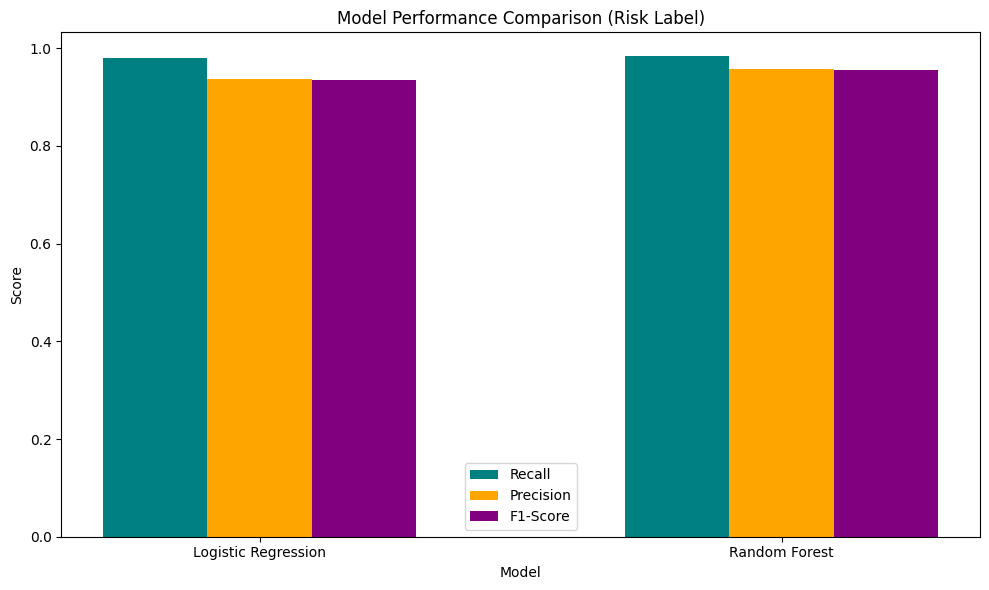

<Figure size 600x600 with 0 Axes>

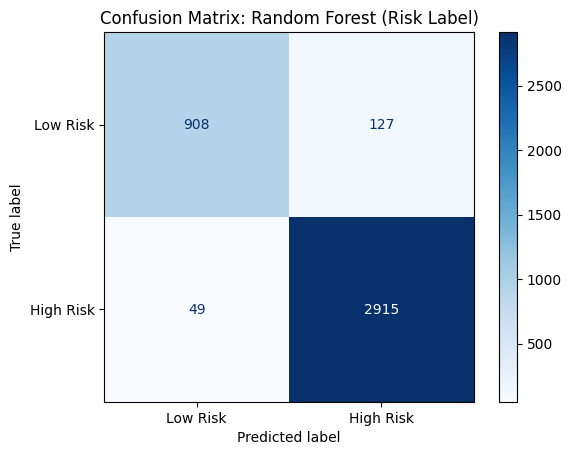

<Figure size 600x600 with 0 Axes>

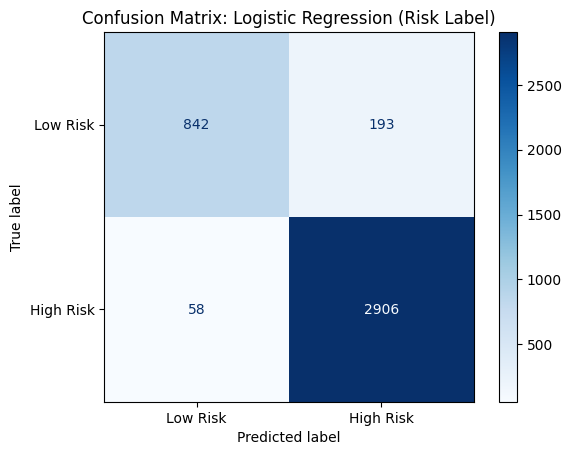

<Figure size 640x480 with 0 Axes>

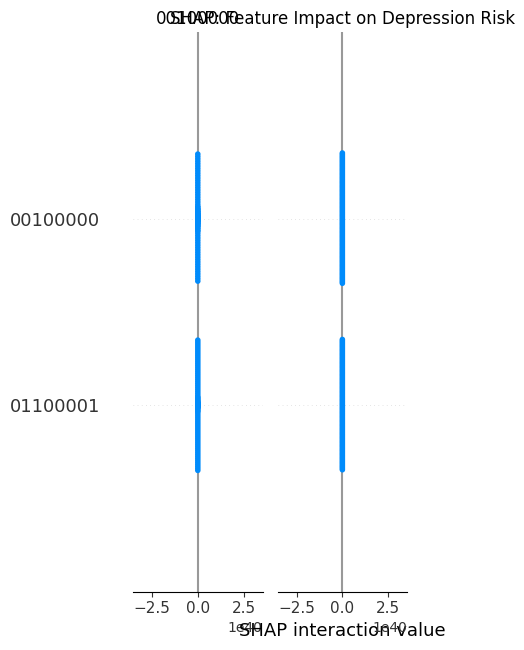

In [16]:
if __name__ == "__main__":
    # Run the pipeline to get the trained model and components
    rf_model, lr_model, tfidf_vec, sentiment_analyzer, label_encoder, _ = run_pipeline()

    # Define the prediction function for Gradio
    def predict_tweet_gradio(user_input):
        text_to_process = user_input
        tweet_content_output = "" # Initialize as empty, only populate if URL is successful

        if user_input.startswith("http"):
            retrieved_text = get_tweet_from_url(user_input)
            if retrieved_text.startswith("ERROR:"):
                # If there's an error retrieving the tweet, display it across all outputs
                return retrieved_text, "N/A", "Please check the URL or enter text manually.", ""
            else:
                text_to_process = retrieved_text
                tweet_content_output = retrieved_text # Populate only if scraped successfully
        # If it's not a URL, tweet_content_output remains an empty string

        clean_in = clean_tweet(text_to_process)
        feat_tfidf = tfidf_vec.transform([clean_in]).toarray()
        feat_sent = sentiment_analyzer.polarity_scores(clean_in)['compound']
        feat_len = len(clean_in)

        feat_full = np.hstack([feat_tfidf, [[feat_sent, feat_len]]])

        pred_raw = lr_model.predict(feat_full)

        try:
            intent_res = label_encoder.inverse_transform([pred_raw[0][1]])[0]
        except:
            intent_res = "Unknown"

        if intent_res == "Cry for Help":
            risk_res = "High Risk"
        elif intent_res == "Venting":
            risk_res = "Moderate Risk"
        elif intent_res == "Loneliness":
            risk_res = "Low Risk"
        elif intent_res == "Neutral":
            risk_res = "No Risk"
        else:
            risk_res = "Uncertain Risk"

        suggestion = get_wellness_suggestion(intent_res)

        # Removed markdown formatting for better presentation in Gradio
        return risk_res, intent_res, suggestion, tweet_content_output


    interface = gr.Interface(
        fn=predict_tweet_gradio,
        inputs=gr.Textbox(lines=5, label="Enter tweet text or a Twitter URL..."),
        outputs=[
            gr.Textbox(label="Risk Level"),
            gr.Textbox(label="Intent"),
            gr.Textbox(label="Wellness Suggestion", lines=4),
            gr.Textbox(label="Tweet Content", lines=5)
        ],
        title="Depression Risk and Intent Classifier for Tweets",
        description="Enter a tweet or a Twitter URL to get a depression risk assessment, intent classification, and a wellness suggestion.",
        theme='gradio/soft',
        flagging_dir="flagged_data"
    )

    interface.launch()
